In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 14.32it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()

elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
from src.strain import *

In [5]:
%matplotlib widget

In [6]:
def get_local_strain_single_video(test_pat_index, test_dataset, model, N, vis=False):
    '''
    input:
        test_pat_index = index of video to get data of
        test_dataset = test dataset object
        model = object loaded onto device
        N = int
    output:
        list of N regions (from top to bottom) of local strain 
        NOTE: this is just completely horizontal cuttings!!!
        
        TODO: use 2d pucks with more accurate slicings
    '''
    curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
    ed_raw_seg_out = curr_clip_segmentations[:,0,...]
    
    ed_one_hot_seg_out = one_hot(ed_raw_seg_out)
    
    split_points = get_split_points(ed_one_hot_seg_out, N, top_bottom_index(ed_one_hot_seg_out))
    
    all_strains = [0 for i in range(N)]
    
    I = ed_one_hot_seg_out
    
    # convert to boundary
    I = cut_basal_plane_out(give_boundary(I))
    
    import copy
    for i in range(N):
        I_copy = copy.deepcopy(I)
        
        start = split_points[i]
        end = split_points[i+1]
        
        I_copy[0:start, 0:I_copy.shape[1]] = 0
        I_copy[end:I_copy.shape[0], 0:I_copy.shape[1]] = 0
        
        # need to use the raw data, but need to also be boundary, no basal plate, and be the same
        # pixels described in the I_copy
        
        print(f'I_copy unique: {np.unique(I_copy)}')
        print(f'I_copy num pixels 0: {np.count_nonzero(I_copy == 0)}')
        print(f'I_copy total pixels: {I_copy.shape[0] * I_copy.shape[1]}')
        
        
        pixels_changed = 0
        pixels_not_changed = 0
        
        z_, height, width = ed_raw_seg_out.shape
        for i in range(height):
            for j in range(width):
                if I_copy[i][j] == 0.0:
                    # the functions don't like me zeroing things out, apparently.
                    # I need to alter the values in a different way (alter the LV weight to be small, to make model think it is not lv
                    # so that we discard this pixel data point)
                    
                    ed_raw_seg_out[:, i, j] = 0
                    # ed_raw_seg_out[0][i][j] = 10
                    # ed_raw_seg_out[1][i][j] = -10
                    
                    # i want this to be zeroed out, I want the first dim val to be larger than the second dim val on this axis
                    
                    # ed_raw_seg_out[0][i][j] = 1e-15
                    # ed_raw_seg_out[1][i][j] = -1e-15
                    
                    pixels_changed += 1
                else:
                    pixels_not_changed += 1
                    print(f'ed_raw_seg_out[0][{i}][{j}] unchanged val: {ed_raw_seg_out[0][i][j]}')
                    print(f'ed_raw_seg_out[1][{i}][{j}] unchanged val: {ed_raw_seg_out[1][i][j]}')
                    
        ed_raw_seg_out_one_hot = one_hot(ed_raw_seg_out)
        
        #vis_pair(I_copy, ed_raw_seg_out_one_hot)
        
        print(f'dice: {get_dice(ed_raw_seg_out_one_hot, I_copy)}')
        
        #return
    
        '''ok till this point '''

        # ed_raw_seg_out[0][0:112][0:112] = 10
    
        # print(f'ed_raw_seg_out[0][0][0]: {ed_raw_seg_out[0][0][0]}')
        # print(f'ed_raw_seg_out[1][0][0]: {ed_raw_seg_out[1][0][0]}')
        
        
        print(f'pixels_changed: {pixels_changed}')
        print(f'pixels_not_changed: {pixels_not_changed}')
        # print(f'percentage of picture zeroed out: {(pixels_changed / (height * width)) * 100}%')
        print(f'ed_raw_seg_out unique: {np.unique(ed_raw_seg_out)}')
        
        
        ''' this is where problems happen '''
        tmp = np.array([ed_raw_seg_out]) # make it shape of (1, 2, 112, 112)
        
        print('enter warped_forward')
        I_copy_warped = warp_forward(tmp, curr_clip_motions, delta_ed_es, clip_index, debug=True)
        print('leave warped_forward')
        
        print('enter one_hot')
        I_copy_warped_one_hot = one_hot(I_copy_warped[0])
        print('leave one_hot')
        
        if vis:
            vis_pair(I_copy, I_copy_warped_one_hot, first_title = 'ED frame', second_title = 'Warped to ES frame', cmap='gray')

        ''' the below will be ok if the above warping is ok '''
        
        print(f'I_copy.shape: {I_copy.shape}')
        print(f'I_copy_warped_one_hot.shape: {I_copy_warped_one_hot.shape}')
        print(f'I_copy unique: {np.unique(I_copy)}')
        
        print(f'I_copy_warped_one_hot unique: {np.unique(I_copy_warped_one_hot)}')
        print(f'I_copy_warped unique: {np.unique(I_copy_warped)}')
        
        print(f'I_copy_warped num 0 val: {np.count_nonzero(I_copy_warped == 0.0)}')
        print(f'ed_raw_seg_out num 0 val: {np.count_nonzero(ed_raw_seg_out == 0.0)}')

        return
        
        curr_sec_strain = boundaries_to_strain(I_copy, I_copy_warped_one_hot)
        all_strains[i] = curr_sec_strain
        
        # return all_strains
        
        
    return all_strains

In [7]:
# test_pat_index = 0

In [8]:
# curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
#                                                                                             test_dataset = test_dataset,
#                                                                                             test_pat_index = test_pat_index)

I_copy unique: [0. 1.]
I_copy num pixels 0: 12499
I_copy total pixels: 12544
ed_raw_seg_out[0][23][48] unchanged val: -0.2729240953922272
ed_raw_seg_out[1][23][48] unchanged val: 0.10149804502725601
ed_raw_seg_out[0][23][49] unchanged val: -1.2538999319076538
ed_raw_seg_out[1][23][49] unchanged val: 1.033583164215088
ed_raw_seg_out[0][23][50] unchanged val: -1.6016182899475098
ed_raw_seg_out[1][23][50] unchanged val: 1.4230374097824097
ed_raw_seg_out[0][23][51] unchanged val: -1.887340784072876
ed_raw_seg_out[1][23][51] unchanged val: 1.7724015712738037
ed_raw_seg_out[0][23][52] unchanged val: -1.7347644567489624
ed_raw_seg_out[1][23][52] unchanged val: 1.6609793901443481
ed_raw_seg_out[0][23][53] unchanged val: -1.2982120513916016
ed_raw_seg_out[1][23][53] unchanged val: 1.2486134767532349
ed_raw_seg_out[0][23][54] unchanged val: -0.4303007423877716
ed_raw_seg_out[1][23][54] unchanged val: 0.4135327935218811
ed_raw_seg_out[0][24][48] unchanged val: -1.3036125898361206
ed_raw_seg_out[1

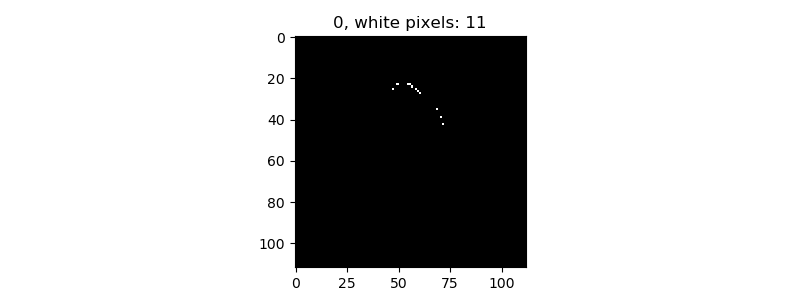

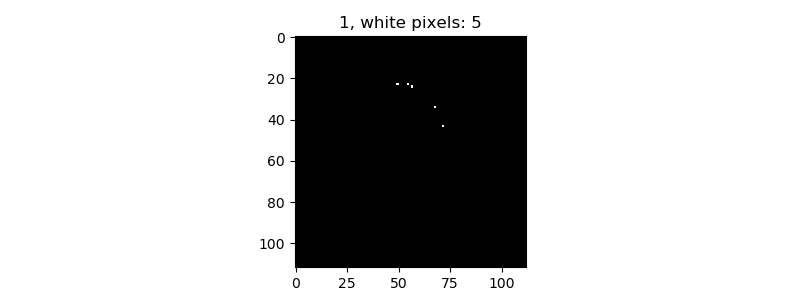

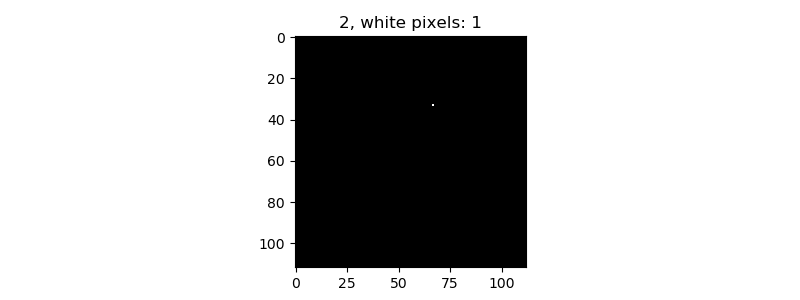

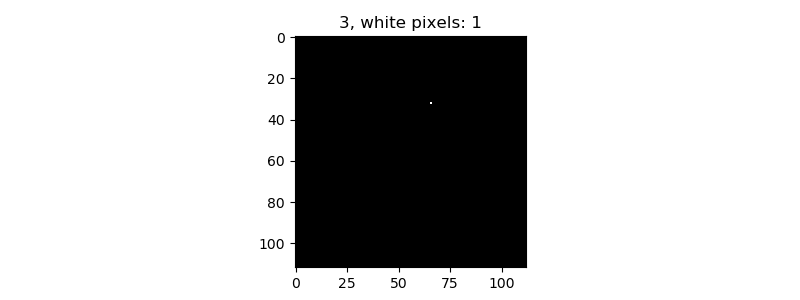

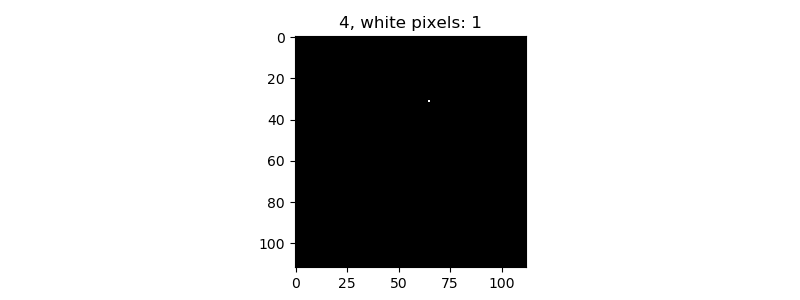

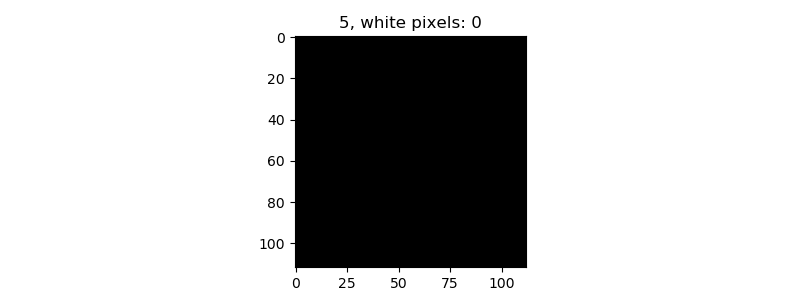

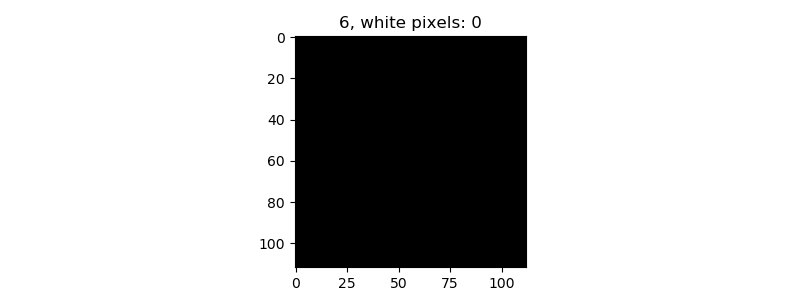

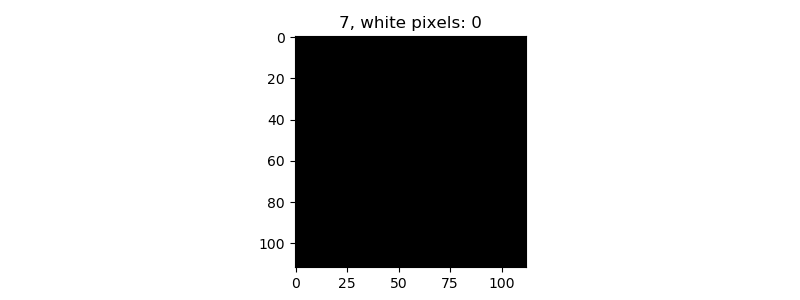

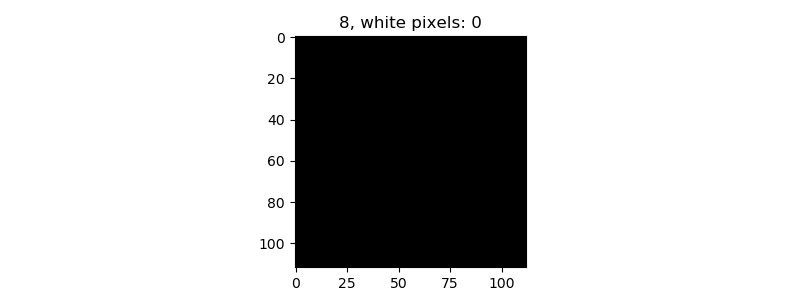

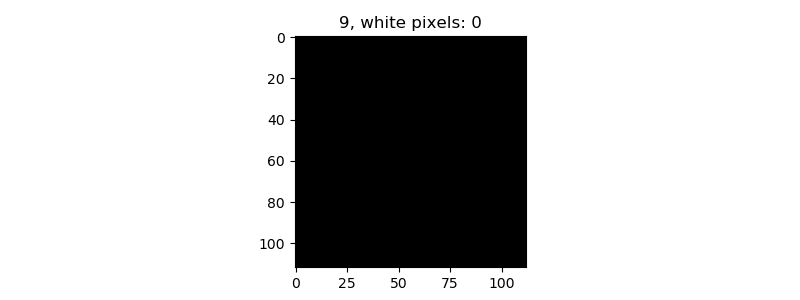

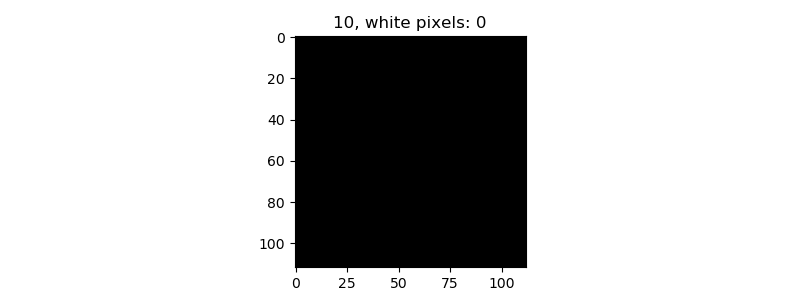

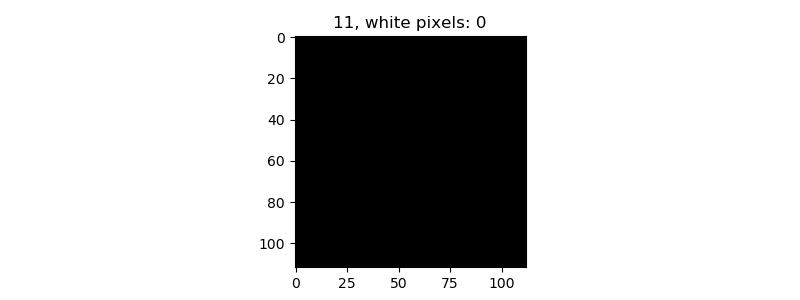

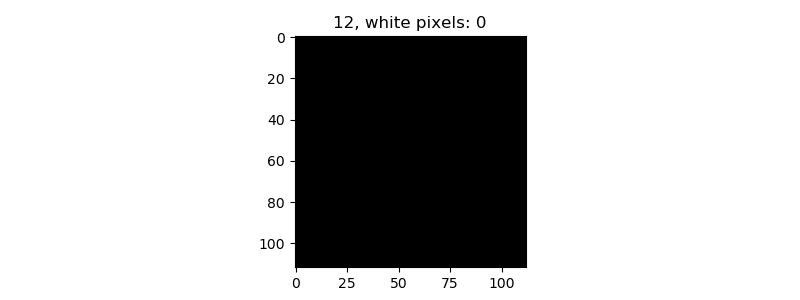

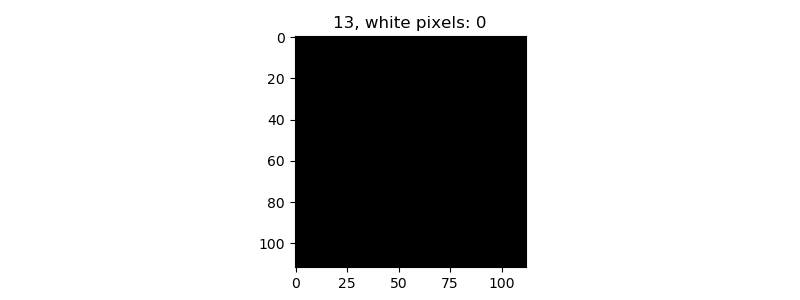

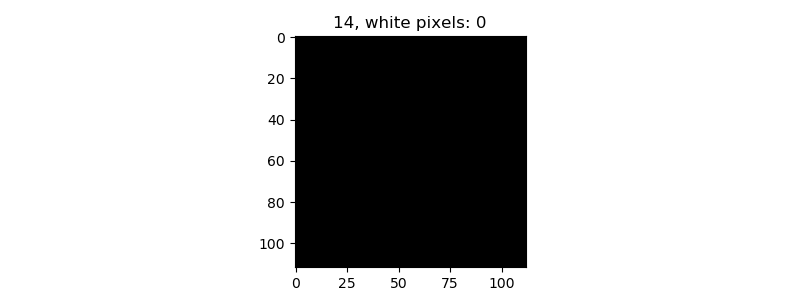

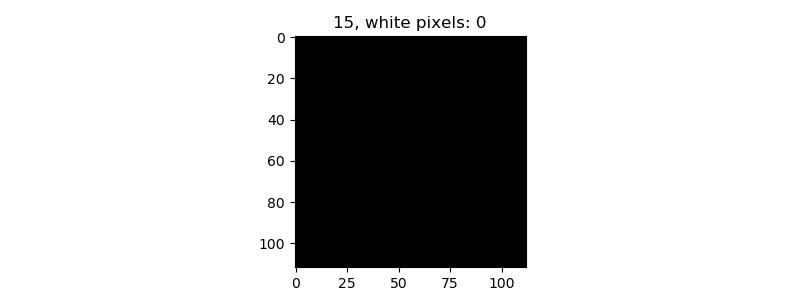

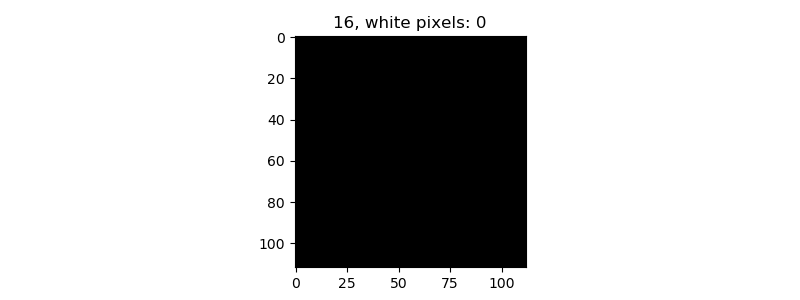

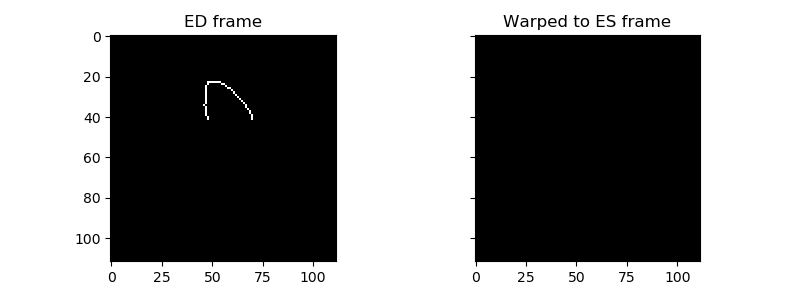

In [9]:
all_strains = get_local_strain_single_video(test_pat_index = 0, 
                                            test_dataset = test_dataset, 
                                            model = model, 
                                            N = 3, 
                                            vis=True)

In [10]:
all_strains